<a href="https://colab.research.google.com/github/kasri-mids/MovieGenreClassification/blob/master/src/Baseline%20BERT/BERT_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model

In this notebook, we load the relevant BERT tokens generated using a pre-trained 12-layer,768-dimensional  hidden  vector,  uncased BERT model and then create a baseline model using the train, dev and val data that we generated previously. The max length of the tokens is 128 in this case.

Within the notebook, there is also code to oversample the data and we test our model, both on the no-oversampled and oversampled dataset.

Further, we use custom loss and accuracy functions which are defined below in the notebook.

### Load Modules <a id="load" />


In [0]:
#%tensorflow_version 2.1
!pip install tensorflow==2.1.0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras import initializers

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Load Dataset <a id="loadData" />


In [0]:
max_length = 128

In [0]:
ERROR_TEST = 0
OVERSAMPLING = False
if (ERROR_TEST):
    NUM_LABELS = 1
    OVERSAMPLING = False

    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/data/baseline_test/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/model/baseline_test/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/plots/baseline_test/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'

else:
    NUM_LABELS = 10
    
    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/data/baseline/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/model/baseline/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlots/plots/baseline/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'

# Baseline Model (One Label)

### Loading the data

In [0]:
X_train = np.load(data_load_prefix + 'clean_train_bert_tokens_' + str(max_length) + '.data.npy')
X_dev = np.load(data_load_prefix + 'clean_dev_bert_tokens_'  + str(max_length) + '.data.npy')
X_val = np.load(data_load_prefix + 'clean_val_bert_tokens_'  + str(max_length) + '.data.npy')

y_train = np.load(data_load_prefix + 'clean_train_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_dev = np.load(data_load_prefix + 'clean_dev_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_val = np.load(data_load_prefix + 'clean_val_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)

In [0]:
print(X_train.shape)
print(X_dev.shape)
print(X_val.shape)

(3, 46970, 128)
(3, 15438, 128)
(3, 15600, 128)


In [0]:
print(y_train.shape)
print(y_dev.shape)
print(y_val.shape)

(46970, 10)
(15438, 10)
(15600, 10)


In [0]:
df = pd.read_csv('/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/clean_poster_data_' + str(NUM_LABELS) + '.csv')
df.head()

,movieid,movieplot,feature_vector,labels
0,tt0007610,A judge who had taken part in the gold rush of...,"[0.7366994023323059, 0.9941093921661377, 1.076...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,tt0005078,"Richard Hardy, a hardworking stockbroker, labo...","[0.002950882539153099, 0.10090522468090057, 1....","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,tt0007257,"Reggie, a wealthy young man about town, is eag...","[0.03462240472435951, 0.500708818435669, 1.862...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
3,tt0008011,"Living in the country with her widowed mother,...","[0.0, 0.06257307529449463, 0.8574206233024597,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,tt0003772,Based on the fairy tale: Cinderella is mistrea...,"[0.2867472171783447, 0.0, 0.9653348922729492, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [0]:
df_train = pd.read_csv(data_load_prefix + 'clean_df_train_labels_' + str(NUM_LABELS) + '.csv')
df_dev = pd.read_csv(data_load_prefix + 'clean_df_dev_labels_' + str(NUM_LABELS) + '.csv')
df_val = pd.read_csv(data_load_prefix + 'clean_df_val_labels_' + str(NUM_LABELS) + '.csv')

In [0]:
print(df_train.shape)
print(df_dev.shape)
print(df_val.shape)

(46970, 5)
(15438, 5)
(15600, 5)


In [0]:
# Oversampling Train Dataset

In [0]:
def oversample_keeping_original(X, y, bottom_n = 6, count_per_category = 5000):
    genre_counts = np.sum(y,axis = 0)
    genre_sorted_index = np.argsort(genre_counts)[:bottom_n]
    np.random.seed(0)
    
    new_y = np.array([])
    new_X = np.array([])
    list_samples = np.array([])
    for index,i in enumerate(genre_sorted_index):
        indices = np.where(y[:,i]>0)
        samples = np.random.choice(indices[0],count_per_category)
        # print(i,samples[-20:])
        if index==0:
            new_y = np.concatenate((y, y[samples,:]), axis = 0)
            new_X = np.concatenate((X, X[:,samples,:]), axis = 1)
            print("index 0 ", np.arange(X.shape[1]))
            list_samples = np.concatenate((np.arange(X.shape[1]) ,samples), axis = 0)
        else:
            new_y = np.concatenate((new_y, y[samples,:]), axis=0)
            new_X = np.concatenate((new_X, X[:,samples,:]),axis=1)
            list_samples = np.concatenate((list_samples, samples), axis=0)

    indexArray = np.arange(0, new_y.shape[0], 1, dtype=np.int32)
    print("Len of index array is ", len(indexArray))

    np.random.seed(0)
    np.random.shuffle(indexArray)

    return (new_X[:,indexArray,:], new_y[indexArray], list_samples[indexArray])

In [0]:
if (OVERSAMPLING):
    new_X_train, new_y_train, list_samples = oversample_keeping_original(X_train, y_train, bottom_n = 6, count_per_category = 5000)
    new_df_train = df_train.iloc[list_samples]
    
    print(np.sum(y_train,axis = 0)/y_train.shape[0])
    print(np.sum(new_y_train,axis = 0)/new_y_train.shape[0])
    
    print(new_X_train.shape)
    print(new_y_train.shape)
    print(len(list_samples))

### Custom Loss and Accuracy Functions

In [0]:
import keras.backend.tensorflow_backend as tfb

#@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

#@tf.function
def micro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y)), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    micro_f1 = f1 #tf.reduce_mean(f1)
    return micro_f1

#@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

#@tf.function
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

#@tf.function
def binary_crossentropy(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # compute loss
    loss = tf.keras.backend.binary_crossentropy(y, y_hat, from_logits=False)
    return tf.reduce_mean(loss, axis=-1)

### BERT Model Params

In [0]:
optimizer_select = 'ADAM'
BATCH_SIZE = 128*8
EPOCHS = 30
LR = 1e-4
LOSS = 'macro_double_soft_f1'
ACC = ['accuracy', macro_f1, micro_f1]

In [0]:
if OVERSAMPLING:
    NUM_TRAIN_SAMPLES = int(np.floor(new_X_train.shape[1] / BATCH_SIZE) * BATCH_SIZE)
else:
    NUM_TRAIN_SAMPLES = int(np.floor(X_train.shape[1] / BATCH_SIZE) * BATCH_SIZE)

NUM_DEV_SAMPLES = int(np.floor(X_dev.shape[1] / BATCH_SIZE) * BATCH_SIZE)
NUM_VAL_SAMPLES = int(np.floor(X_val.shape[1] / BATCH_SIZE) * BATCH_SIZE)

TRAIN_BERT = True

if (TRAIN_BERT):
    if (OVERSAMPLING):
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS)
    else:
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoOS'
else:
    if (OVERSAMPLING):
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoFT'
    else:
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoFT' + '_NoOS'



In [0]:
print("Number Train Samples ", NUM_TRAIN_SAMPLES)

Number Train Samples  46080


In [0]:
def filter_data(X, y, n_size, reverse=False):
    if (reverse):
        X_out = [X[0][-n_size:].astype('int32'), X[1][-n_size:].astype('int32'),X[2][-n_size:].astype('int32')]
        y_out = y[-n_size:].astype('int32')
    else:
        X_out = [X[0][0:n_size].astype('int32'), X[1][0:n_size].astype('int32'),X[2][0:n_size].astype('int32')]
        y_out = y[0:n_size].astype('int32')
    
    return (X_out, y_out)

rev = False

if OVERSAMPLING:
    bert_inputs_train_k, labels_train_k = filter_data(new_X_train, 
                                                    new_y_train, 
                                                    NUM_TRAIN_SAMPLES, 
                                                    reverse=rev)
else:
    bert_inputs_train_k, labels_train_k = filter_data(X_train, 
                                                    y_train, 
                                                    NUM_TRAIN_SAMPLES, 
                                                    reverse=rev)    

bert_inputs_dev_k, labels_dev_k = filter_data(X_dev, 
                                            y_dev, 
                                            NUM_DEV_SAMPLES, 
                                            reverse=rev)
bert_inputs_val_k, labels_val_k = filter_data(X_val, 
                                            y_val, 
                                            NUM_VAL_SAMPLES, 
                                            reverse=rev)

In [0]:
OVERSAMPLING

False

### Training BERT Model

In [0]:
def select_optimizer(optimizer_select):
    if optimizer_select == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, name='Adam')
    elif optimizer_select == 'ADAMAX':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')
    elif optimizer_select == 'ADAGRAD':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=LR, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad')
    elif optimizer_select == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9, nesterov=True, name='SGD', clipvalue=0.5)
    elif optimizer_select == 'ADADELTA':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
    else:
        raise Exception('Optimizer not available')
    
    return optimizer

In [0]:
def select_loss(LOSS):
    if LOSS == 'bce':
        loss = binary_crossentropy
    elif LOSS == 'macro_double_soft_f1':
        loss = macro_double_soft_f1
    elif LOSS == 'macro_soft_f1':
        loss = macro_soft_f1
    else:
        raise Exception('Loss function not implemented...')

    return loss

In [0]:
def set_strategy():
    #this is for bfloat16 precision
    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_policy(policy)

    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

    return policy, strategy

In [0]:
policy, strategy = set_strategy()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=1e-4,
                                              patience=10)]
optimizer = select_optimizer(optimizer_select)
loss = select_loss(LOSS)

with strategy.scope():
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")

    bert_inputs = [input_word_ids, input_mask, segment_ids]

    bert_layer = hub.KerasLayer("gs://w266-finalproject/bert_models/bert_en_uncased_L-12_H-768_A-12/1", 
                                name='bert',
                                trainable=TRAIN_BERT)
    pooled_output, sequence_output= bert_layer(bert_inputs)
    pooled_output = tf.keras.layers.Dropout(rate=0.5)(pooled_output)

    dense = tf.keras.layers.Dense(5120, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                  name='Dense_1'
                                  )(pooled_output)
    dense = tf.keras.layers.Dropout(rate=0.5)(dense)

    dense = tf.keras.layers.Dense(5120, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                  name='Dense_2'
                                  )(dense)
    dense = tf.keras.layers.Dropout(rate=0.5)(dense)

    pred = tf.keras.layers.Dense(NUM_LABELS,
                                 activation='sigmoid',
                                 name='pred')(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.summary()

    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=ACC)

    history = model.fit(
        bert_inputs_train_k,  
        labels_train_k,
        validation_data=(bert_inputs_dev_k, labels_dev_k),
        epochs=EPOCHS,
        callbacks=callbacks,
        batch_size=BATCH_SIZE
    )

INFO:tensorflow:Initializing the TPU system: 10.101.168.122:8470


INFO:tensorflow:Initializing the TPU system: 10.101.168.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


45056/46080 [============================>.] - ETA: 2s - loss: 1.1245 - accuracy: 0.1939 - macro_f1: 0.0901 - micro_f1: 0.2922WARNING:tensorflow:5 out of the last 5 calls to <function recreate_function.<locals>.restored_function_body at 0x7fa9c62c5268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


46080/46080 [==============================] - 119s 3ms/sample - loss: 1.1241 - accuracy: 0.1939 - macro_f1: 0.0911 - micro_f1: 0.2924 - val_loss: 1.1094 - val_accuracy: 0.1946 - val_macro_f1: 0.1745 - val_micro_f1: 0.3323
Epoch 2/30
46080/46080 [==============================] - 31s 662us/sample - loss: 1.0949 - accuracy: 0.1954 - macro_f1: 0.1415 - micro_f1: 0.3057 - val_loss: 1.0871 - val_accuracy: 0.1965 - val_macro_f1: 0.1665 - val_micro_f1: 0.3486
Epoch 3/30
46080/46080 [==============================] - 31s 663us/sample - loss: 1.0725 - accuracy: 0.1978 - macro_f1: 0.1903 - micro_f1: 0.3454 - val_loss: 1.0639 - val_accuracy: 0.1896 - val_macro_f1: 0.2865 - val_micro_f1: 0.3485
Epoch 4/30
46080/46080 [==============================] - 31s 663us/sample - loss: 1.0491 - accuracy: 0.1968 - macro_f1: 0.2797 - micro_f1: 0.3597 - val_loss: 1.0547 - val_accuracy: 0.1993 - val_macro_f1: 0.2519 - val_micro_f1: 0.3607
Epoch 5/30
46080/46080 [==============================] - 31s 663us/samp

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_save_prefix + '/' + results_prefix + '_json.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights( model_save_prefix + '/' + results_prefix + '_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


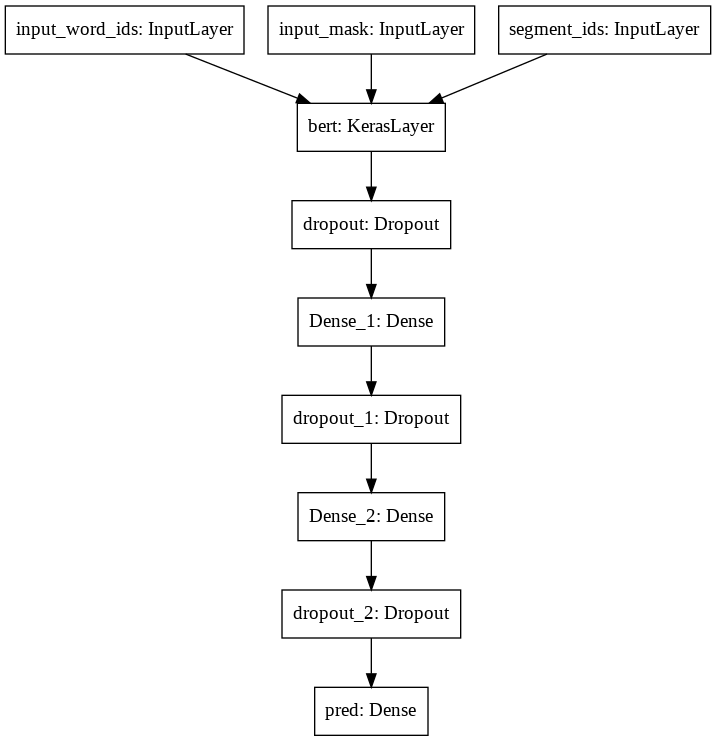

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=plot_save_prefix + 'model_architecture.png')

### Evaluating Results

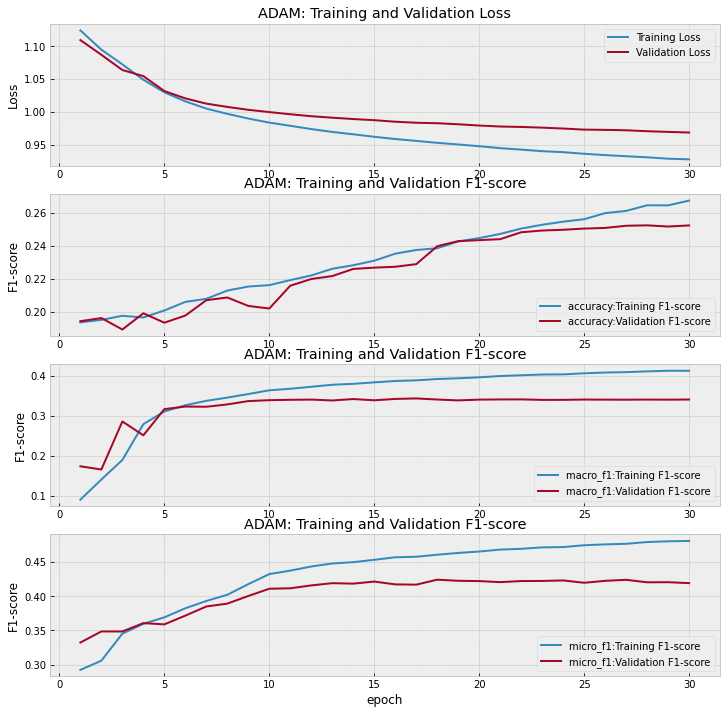

,loss,val_loss,macro_f1,micro_f1,val_macro_f1,val_micro_f1
0,1.124112,1.109428,0.193902,0.091086,0.194596,0.174486
1,1.094925,1.087054,0.195378,0.141518,0.196484,0.166509
2,1.072491,1.063940,0.197830,0.190345,0.189583,0.286509
3,1.049089,1.054660,0.196832,0.279747,0.199349,0.251911
4,1.030084,1.031957,0.201042,0.311534,0.193685,0.317316


In [0]:
import matplotlib.pyplot as plt
import matplotlib.style as style

def learning_curves(history,ACC):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = len(loss)
    style.use("bmh")
    num_plots = len(ACC) + 1
    plt.figure(figsize=(12, 12))

    plt.subplot(num_plots, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title(optimizer_select + ': Training and Validation Loss')

    ctr = 2
    accuracy = []
    val_accuracy = []
    for accs in ACC:
        if isinstance(accs, str):
            acc_name = accs
        else:
            acc_name = accs.__name__
        acc_data = history.history[acc_name]
        val_acc_data = history.history['val_'+acc_name]
        accuracy.append(acc_data)
        val_accuracy.append(val_acc_data)
        plt.subplot(num_plots, 1, ctr)
        plt.plot(range(1, epochs+1), acc_data, label= acc_name + ':' + 'Training F1-score')
        plt.plot(range(1, epochs+1), val_acc_data, label = acc_name + ':' + 'Validation F1-score')
        plt.legend(loc='lower right')
        plt.ylabel('F1-score')
        plt.title(optimizer_select + ': Training and Validation F1-score')

        plt.savefig(plot_save_prefix + results_prefix + '.jpg')
        ctr+=1
    plt.xlabel('epoch')
    plt.show()
    return loss, val_loss, accuracy, val_accuracy

losses, val_losses,  accuracy, val_accuracy = learning_curves(history, ACC)
df_results = pd.DataFrame({'loss':losses,'val_loss': val_losses,
              'macro_f1':accuracy[0],'micro_f1':accuracy[1],
              'val_macro_f1':val_accuracy[0], 'val_micro_f1':val_accuracy[1]})
df_results.head()

In [0]:
df_results.tail()

,loss,val_loss,macro_f1,micro_f1,val_macro_f1,val_micro_f1
25,0.934564,0.972921,0.259635,0.408739,0.250716,0.341005
26,0.932838,0.972308,0.260959,0.409742,0.252018,0.340876
27,0.931242,0.970864,0.264345,0.411672,0.252279,0.341196
28,0.929098,0.969840,0.264301,0.413167,0.251563,0.340958
29,0.928108,0.968890,0.267166,0.413106,0.252214,0.341357


In [0]:
df_results.to_csv(plot_save_prefix + results_prefix+ '.data', index=False)

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'macro_f1', 'micro_f1', 'val_loss', 'val_accuracy', 'val_macro_f1', 'val_micro_f1'])

In [0]:
from tensorflow.keras.models import model_from_json

# load json and create model
with open(model_save_prefix + '/' + results_prefix + '_json.json', "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json, custom_objects = {
    'KerasLayer': hub.KerasLayer
})

# load weights into new model
loaded_model.load_weights(model_save_prefix + '/' + results_prefix + '_weights.h5')
print("Loaded model from disk")

Loaded model from disk


In [0]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [0]:
if (ERROR_TEST):
    label_names = ['Drama']
else:
    label_names = ['Drama','Thriller','Comedy','Action','Crime',
                   'Horror','Romance','Adventure','Mystery','Sci-Fi']

In [0]:
n_thresh = 20
with strategy.scope():
    grid_train = perf_grid(bert_inputs_train_k, 
            labels_train_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)
    grid_dev = perf_grid(bert_inputs_dev_k, 
            labels_dev_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)
    grid_val = perf_grid(bert_inputs_val_k, 
            labels_val_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)

In [0]:
import seaborn as sns

def table_scores(grid_data, threshold):
    max_perf = grid_data.loc[grid_data.threshold==threshold,:].groupby(['id', 'label', 'threshold','freq','precision','recall'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
    max_perf.rename(columns={'f1':'f1score'}, inplace=True)
    max_perf.style.background_gradient(subset=['freq', 'f1score'], 
                                       cmap=sns.light_palette("lightgreen", as_cmap=True))
    return(max_perf)

table_scores(grid_train, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_train.f1score')
table_scores(grid_dev, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_dev.f1score')
table_scores(grid_val, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_val.f1score')
print(table_scores(grid_train, threshold=0.5))
print(table_scores(grid_dev, threshold=0.5))
print(table_scores(grid_val, threshold=0.5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.673953  0.713262  0.693051
1   1   Thriller        0.5  0.20   0.473210  0.471116  0.472161
2   6    Romance        0.5  0.20   0.396963  0.518693  0.449736
3   5     Horror        0.5  0.12   0.393424  0.514801  0.446002
4   2     Comedy        0.5  0.34   0.440690  0.422878  0.431601
5   9     Sci-Fi        0.5  0.06   0.300725  0.575855  0.395113
6   3     Action        0.5  0.15   0.352260  0.438088  0.390514
7   4      Crime        0.5  0.13   0.272949  0.399773  0.324406
8   8    Mystery        0.5  0.07   0.223304  0.451926  0.298911
9   7  Adventure        0.5  0.09   0.204148  0.393792  0.268896
   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.627106  0.683176  0.653941
1   6    Romance        0.5  0.20   0.348953  0.451759  0.393756
2   1   Thriller        0.5  0.19   0.382766  0.383534  0.383149
3   2     Comedy        0

In [0]:
plot_save_prefix + results_prefix

'/content/drive/My Drive/w266-FinalProject/MoviePlots/plots/baseline/baseline_seqlen_128_ADAM_EPOCHS_30_LR_0.0001_LOSS_macro_double_soft_f1_NoOS'

In [0]:
# Only for Baseline Error Testing with 1 Label
if (NUM_LABELS == 1):
    from sklearn.metrics import confusion_matrix

    out_data = ''

    num_results = NUM_TRAIN_SAMPLES
    bert_inputs_infer = [bert_inputs_train_k[0][:num_results], bert_inputs_train_k[1][:num_results], bert_inputs_train_k[2][:num_results]]

    result_train = model.predict(
        bert_inputs_infer, 
        batch_size=BATCH_SIZE
    )

    # Putting the threshold at 0.5
    threshold = 0.5

    out_data = out_data + 'Confusion matrix for train...\n'
    out_data = out_data + str(confusion_matrix(y_train[:num_results].astype(np.int), (result_train > threshold).astype(np.int))) + '\n'

    print('Confusion matrix for train...')
    print(confusion_matrix(y_train[:num_results].astype(np.int), (result_train > threshold).astype(np.int)))

    num_results = NUM_VAL_SAMPLES
    bert_inputs_infer = [bert_inputs_val_k[0][:num_results], bert_inputs_val_k[1][:num_results], bert_inputs_val_k[2][:num_results]]

    result_val = model.predict(
        bert_inputs_infer, 
        batch_size=BATCH_SIZE
    )

    out_data = out_data + 'Confusion matrix for train...\n'
    out_data = out_data + str(confusion_matrix(y_val[:num_results].astype(np.int), (result_val > threshold).astype(np.int))) + '\n'
    print('Confusion matrix for val...')
    print(confusion_matrix(y_val[:num_results].astype(np.int), (result_val > threshold).astype(np.int)))


    num_results = NUM_DEV_SAMPLES
    bert_inputs_infer = [bert_inputs_dev_k[0][:num_results], bert_inputs_dev_k[1][:num_results], bert_inputs_dev_k[2][:num_results]]

    result_dev = model.predict(
        bert_inputs_infer, 
        batch_size=BATCH_SIZE
    )

    out_data = out_data + 'Confusion matrix for train...\n'
    out_data = out_data + str(confusion_matrix(y_dev[:num_results].astype(np.int), (result_dev > threshold).astype(np.int))) + '\n'
    print('Confusion matrix for dev...')
    print(confusion_matrix(y_dev[:num_results].astype(np.int), (result_dev > threshold).astype(np.int)))


    with open(model_save_prefix + results_prefix + 'cm.data', 'a') as the_file:
        the_file.write(out_data)
